# Peak intensity comparison
Scripts used to generate supplementary figure 3 of the manuscript:
>**The future of peptide-centric Data-Independent Acquisition is predicted**  
>_Bart Van Puyvelde\*, Sander Willems\*, Ralf Gabriels\*, Simon Daled, Laura De Clerck, An Staes, Francis Impens, Dieter Deforce, Lennart Martens, Sven Degroeve, Maarten Dhaenens_  
>2019 bioRxiv doi: https://doi.org/10.1101/681429

> Pearson correlation coefficients between the experimental spectra from the Narrow and Wide-Window HeLa DIA data of the EncyclopeDIA article and the source libraries from DDA or MS²PIP and Prosit, as well as the chromatogram libraries derived from DDA or MS²PIP and Prosit.

## Merge all library output files
Exported from EncyclopeDIA as OpenSWATH TSV files after every search.

```python
import os
import pandas as pd

path = 'EncyclopeDIA_exports'
source_libs = ['PanHuman', 'MS2PIPClone', 'PrositClone']
dataset = ['NarrowChromatogramLibrary', 'WideChromatogramLibrary', 'SourceLibrary']

to_concat = []
for source in source_libs:
    for ds in dataset:
        tmp = pd.read_csv(os.path.join(path, f'{source}_{ds}.tsv'), sep='\t')
        tmp['source_lib'] = source
        tmp['dataset'] = ds
        to_concat.append(tmp)
datasets = pd.concat(to_concat, axis=0)
datasets.to_hdf('all_datasets.h5', key='table')
```

All EncyclopeDIA exports and `all_datasets.h5` can be downloaded from [genesis.ugent.be/uvpublicdata/MS2PIP-for-DIA/peak_intensity_comparison](http://genesis.ugent.be/uvpublicdata/MS2PIP-for-DIA/peak_intensity_comparison/)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('deep')

In [2]:
datasets = pd.read_hdf('all_datasets.h5', key='table')

## Number of unique peptides per dataset

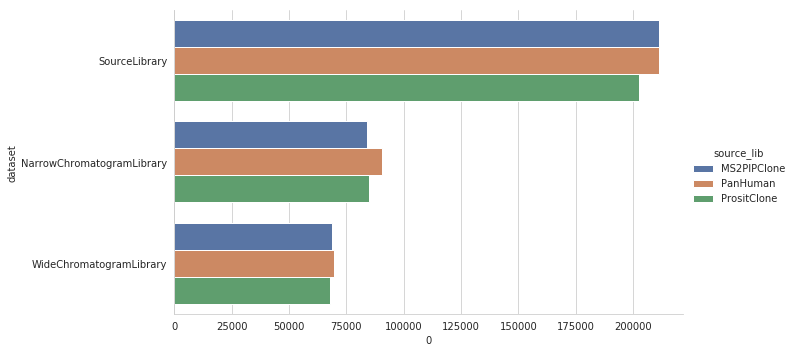

In [3]:
unique_peptides = datasets[~datasets.duplicated(['transition_group_id', 'source_lib', 'dataset'])]
gb = unique_peptides.groupby(['source_lib', 'dataset']).size().reset_index()

sns.catplot(
    data=gb, y='dataset', x=0, hue='source_lib',
    kind='bar', orient='h', aspect=2, order=['SourceLibrary', 'NarrowChromatogramLibrary', 'WideChromatogramLibrary'],
)
plt.show()

## Calculate correlations
**Define functions to calculate correlations for given datasets**

In [4]:
from itertools import product
from multiprocessing import Pool

import numpy as np
from scipy.stats import pearsonr


def spectrum_pearson(true, pred):
    """
    Return pearson of tic-normalized, log2-transformed intensities, 
    the MS2PIP way.
    """
    tic_norm = lambda x: x / np.sum(x)
    log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        log_transform(tic_norm(true)), 
        log_transform(tic_norm(pred))
    )[0]
    return corr


def merge_intensities(left, right):
    merge_cols = [
        'PeptideSequence', 'PrecursorCharge', 'ProductCharge',
        'FragmentIonType', 'FragmentSeriesNumber',
    ]

    left = left.rename(columns={'LibraryIntensity': 'intensity_left'})
    right = right[merge_cols + ['LibraryIntensity']].rename(columns={'LibraryIntensity': 'intensity_right'})

    merge = left.merge(right, on=merge_cols)
    return merge


def correlate_mp(args):
    """
    Calculate correlations for a given source library, and left and right datasets.
    """
    source_lib, (left, right) = args
    merge = merge_intensities(
        datasets[(datasets['source_lib'] == source_lib) & (datasets['dataset'] == left)],
        datasets[(datasets['source_lib'] == source_lib) & (datasets['dataset'] == right)]
    )

    gb_cols = ['transition_group_id', 'intensity_left', 'intensity_right']
    corr = merge[gb_cols]\
        .groupby('transition_group_id').corr(method=spectrum_pearson).iloc[::2,1]\
        .reset_index()[['transition_group_id', 'intensity_right']]\
        .rename(columns={'intensity_right': 'correlation'})

    corr['source_lib'] = source_lib
    corr['left'] = left
    corr['right'] = right

    return corr

**Filter out y1 ions and peptides with less than 5 transitions**

In [5]:
num_transitions = datasets.groupby(['transition_group_id', 'source_lib', 'dataset'])\
    .size()\
    .reset_index()\
    .rename(columns={0: 'num_transitions'})

datasets = datasets.merge(num_transitions, on=['transition_group_id', 'source_lib', 'dataset'])

datasets = datasets[
    ~(
        (datasets['FragmentIonType'] == 'y') &
        (datasets['FragmentSeriesNumber'] == 1)
    ) &
    datasets['num_transitions'].ge(5)
]

**Calculate correlations for all datasets, using multiprocessing**

In [6]:
comparisons = [
    ('SourceLibrary', 'WideChromatogramLibrary'),
    ('SourceLibrary', 'NarrowChromatogramLibrary'),
    ('NarrowChromatogramLibrary', 'WideChromatogramLibrary'),
]
source_libs = ['PanHuman', 'MS2PIPClone', 'PrositClone']
combinations = product(source_libs, comparisons)

with Pool(10) as p:
    all_corr = p.map(correlate_mp, combinations)
    
all_corr = pd.concat(all_corr, axis=0)
all_corr.to_hdf('all_correlations.h5', key='table')

/home/compomics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/compomics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/compomics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/compomics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/compomics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/compomics/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/compomics/anaconda3/lib/python3.7/site-packages/scipy/stat

**Plot**

In [7]:
#all_corr = pd.read_hdf('all_correlations.h5', key='table')

In [8]:
all_corr['comparison'] = all_corr['left'] + ' vs ' + all_corr['right']

In [10]:
xtick_locations = [-0.27, -0.01, 0.25, 0.73, 0.99, 1.25, 1.73, 1.99, 2.25]
xtick_text = [
    "(a) DDA source library & Wide DIA",
    "(b) MS²PIP source library & Wide DIA",
    "(b) Prosit source library & Wide DIA",
    "(f*) DDA source library & Narrow DIA",
    "(c*) MS²PIP source library & Narrow DIA",
    "(c*) Prosit source library & Narrow DIA",
    "(f) DDA chromatogram library & Wide DIA",
    "(c) MS²PIP chromatogram library & Wide DIA",
    "(c) Prosit chromatogram library & Wide DIA",
]

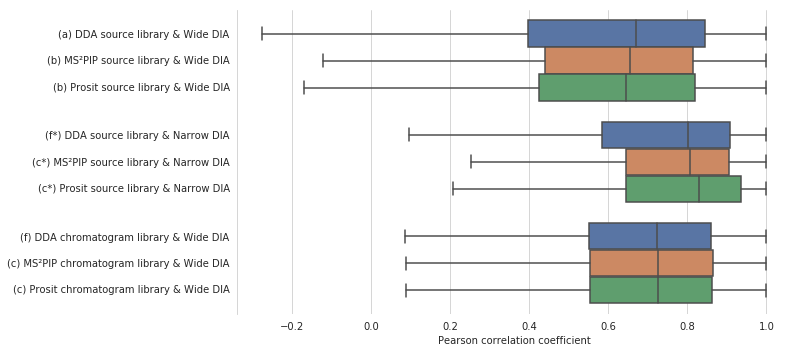

In [11]:
ax = sns.catplot(
    data=all_corr, x='correlation', y='comparison', hue='source_lib', 
    kind='box', orient='h', showfliers=False, aspect=2.5, legend=False, fliersize=0.01
)
sns.despine(left=False, bottom=True)
plt.ylabel('')
plt.xlabel('Pearson correlation coefficient')
plt.yticks(xtick_locations, xtick_text)
plt.savefig('all_correlations.svg', transparent=True, dpi=300)
plt.show()